# DA6401- Exploring Convolutional Neural Networks Fine-tuning GoogLeNet

## Aravindan Kamatchi Sundaram MM21B010

Loading the datasets for finetuning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/nature_12K/inaturalist_12K/train" "/content/train"

In [ ]:
!cp -r "/content/drive/MyDrive/nature_12K/inaturalist_12K/test" "/content/test"

Loading pre-trained GoogLeNet, unfreezing of last layer and light-weight training(to prevent catastrophic forgetting).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Load datasets
train_data = datasets.ImageFolder(root="/content/train", transform=transform_train)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

# Load pre-trained GoogLeNet
model = models.googlenet(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 10 classes and unfreeze only it
model.fc = nn.Linear(model.fc.in_features, 10)
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Train for 3 epochs (lightweight training)
epochs = 3
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 117MB/s]
Epoch 1/3: 100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


Epoch 1, Loss: 1.3871


Epoch 2/3: 100%|██████████| 313/313 [02:14<00:00,  2.33it/s]


Epoch 2, Loss: 1.0739


Epoch 3/3: 100%|██████████| 313/313 [02:10<00:00,  2.41it/s]

Epoch 3, Loss: 1.0071


Testing the fine-tuned model

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
test_data = datasets.ImageFolder(root="/content/test", transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
# Evaluate accuracy on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

accuracy = 100 * correct / total
print(f"\nTest Accuracy: {accuracy:.2f}%")


Test Accuracy: 69.50%


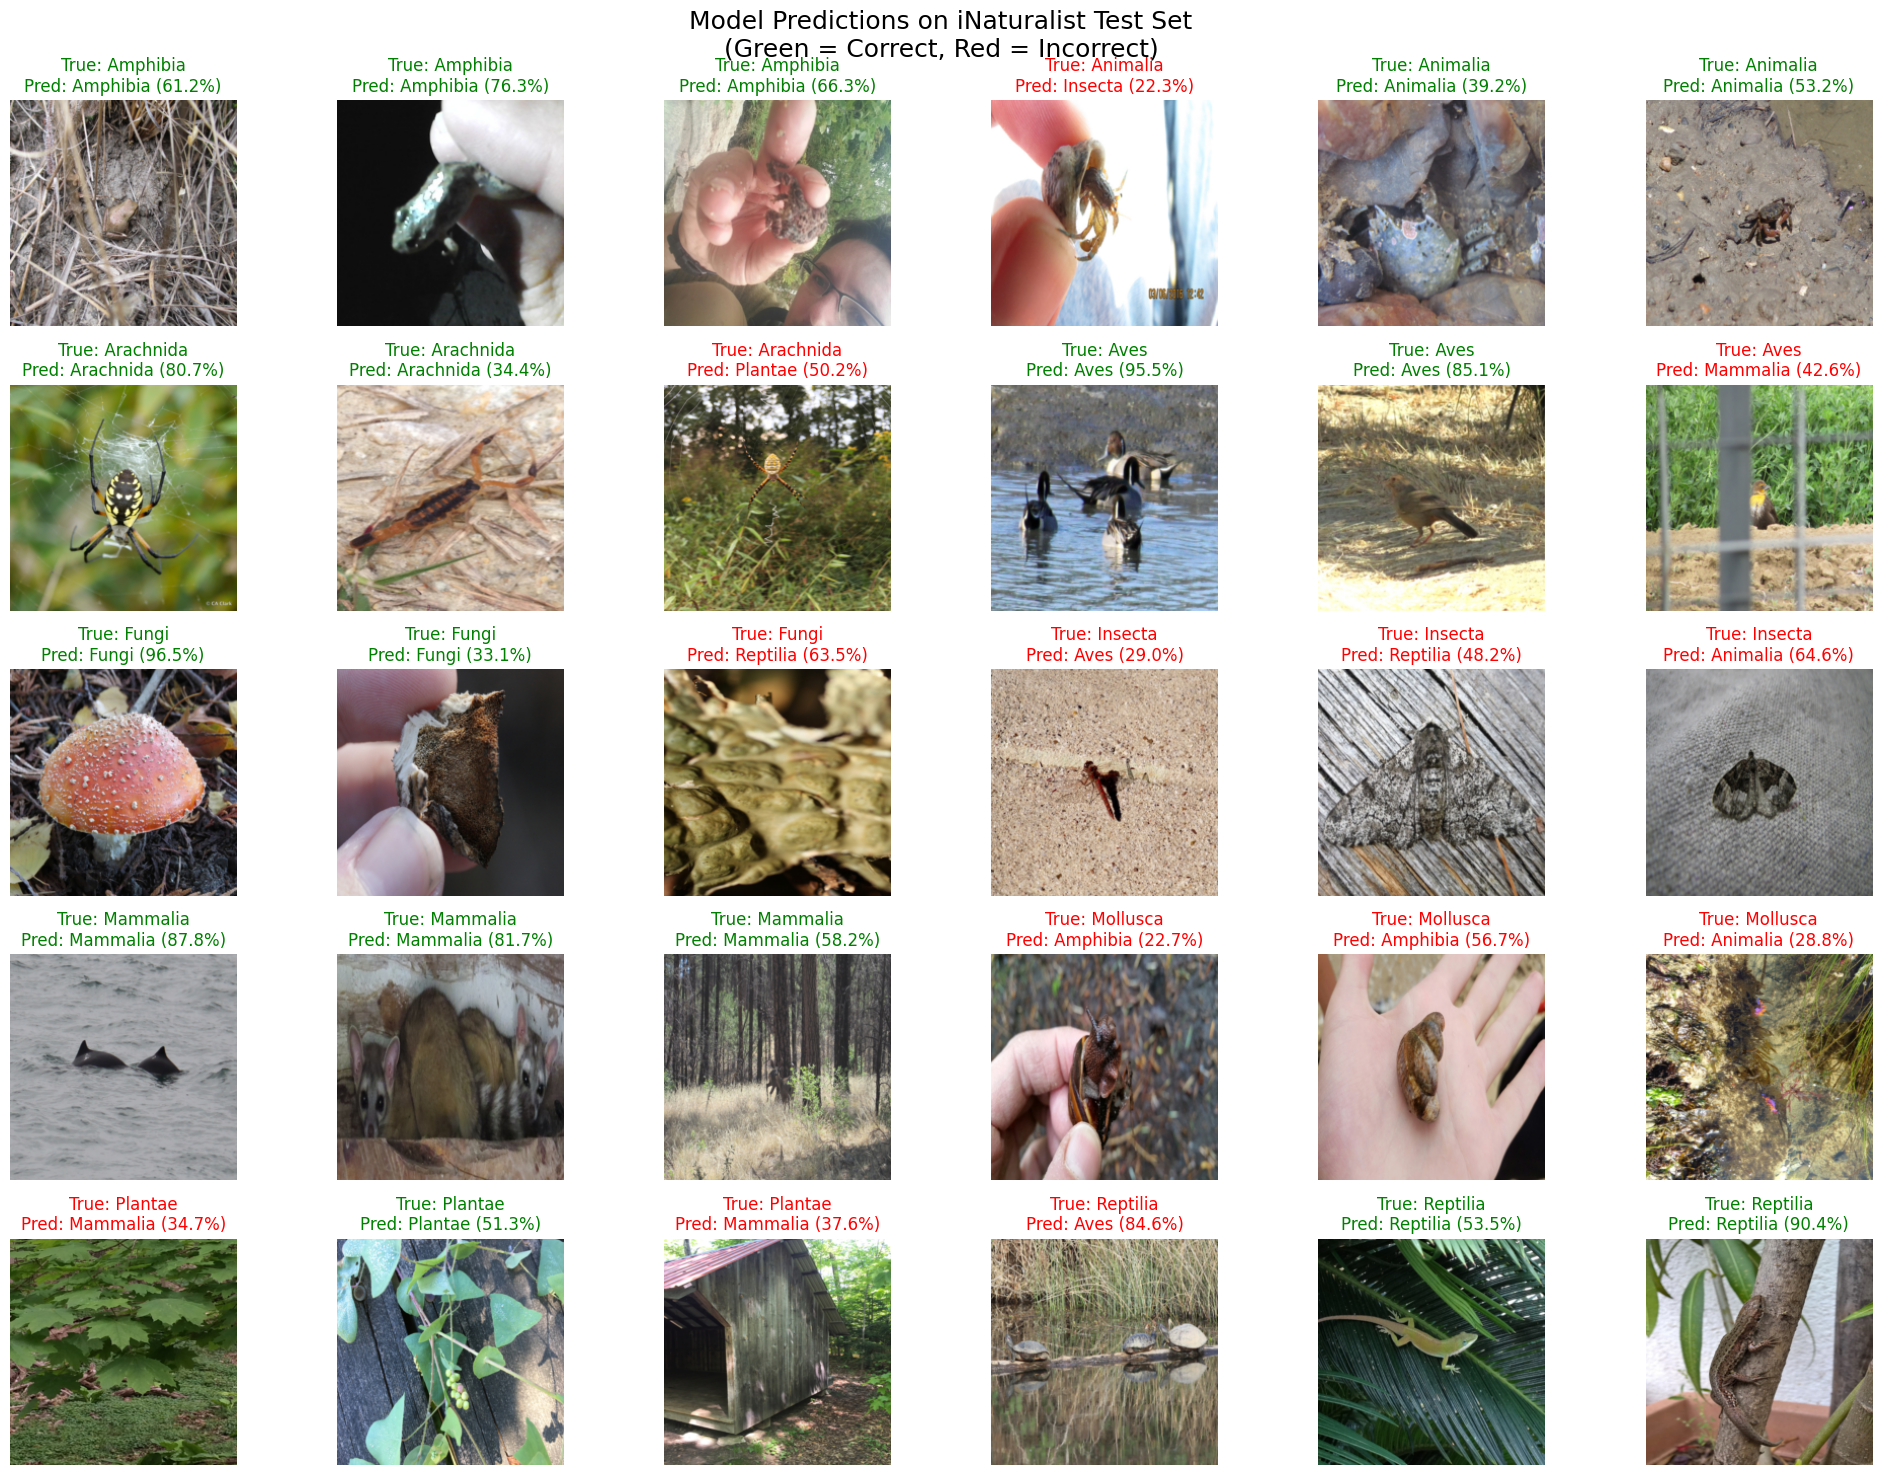

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from collections import defaultdict

model.eval()
class_names = test_data.classes

# Collect 3 images per class
images_per_class = defaultdict(list)
max_per_class = 3

with torch.no_grad():
    for img, label in test_data:
        if len(images_per_class[label]) < max_per_class:
            images_per_class[label].append((img, label))
        if all(len(v) == max_per_class for v in images_per_class.values()) and len(images_per_class) == 10:
            break

# Create lists for inference
final_images, final_labels = [], []
for cls in range(10):
    for img, lbl in images_per_class[cls]:
        final_images.append(img)
        final_labels.append(lbl)

# Stack and move to device
final_images_tensor = torch.stack(final_images).to(device)

# Inference with confidence
with torch.no_grad():
    outputs = model(final_images_tensor)
    probs = F.softmax(outputs, dim=1)
    confs, preds = torch.max(probs, 1)

# Prepare for plotting
final_images_tensor = final_images_tensor.cpu()
preds = preds.cpu()
confs = confs.cpu().numpy()
final_labels = torch.tensor(final_labels)

# Plotting
fig, axes = plt.subplots(5, 6, figsize=(20, 15))
for i, ax in enumerate(axes.flat):
    img = final_images_tensor[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)

    true_class = class_names[final_labels[i]]
    pred_class = class_names[preds[i]]
    confidence = confs[i] * 100

    title_color = "green" if preds[i] == final_labels[i] else "red"
    ax.set_title(f"True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)", color=title_color)
    ax.axis("off")

plt.suptitle("Model Predictions on iNaturalist Test Set\n(Green = Correct, Red = Incorrect)", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [ ]:
# Save the fine-tuned model
torch.save(model.state_dict(), 'googlenet_finetuned.pth')
print("Model saved as googlenet_finetuned.pth")

Model saved as googlenet_finetuned.pth


Details and inferences are present and elaborated in the WandB report.